# Water/`lickometer` preprocessing and feature extraction

### This notebook at a glance
1. A mouse drinks approximately 3-5 grams (or mLs) of water a day depending on size, amount of food consumed, and infection status.
2. The water bottles likely leak. The way in which they leak is unclear, but three possibilities are that (a) during drinks the mice pull more water from the tube than they drink, (b) evaporation causes loss, and (c) there are discrete droplets that fall from the waterbottle naturally.

    


Below is the trace of the weight of water in the water bottle for a healthy mouse (mouse 1, from infection experiment started on 06/23/2015) over a ~13h time span (grey is night, so high activity). The x-axis is the number of seconds since the beginning of the experiment, and the y-axis is the water weight remaining in the water bottle.

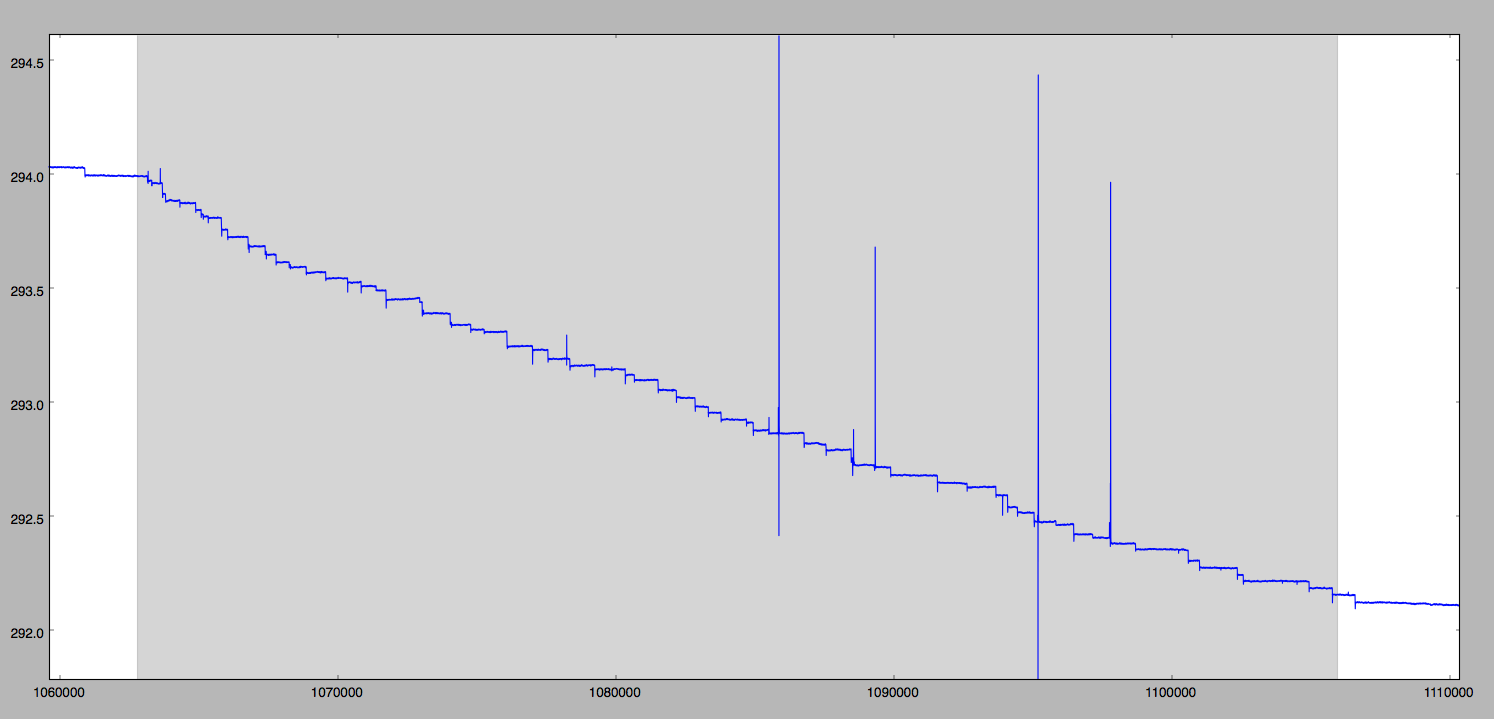

In [1]:
%matplotlib inline
from IPython.display import Image
Image('./drinking/water_usage_example.png')

The below plot shows the healthy (green) and infected (red) mice, over the entire ~25 day experiment. Three differences are clear:
1. Differences caused by infection - i.e. the infected mice don't drink (or drink very little) during the period we believe to be maximal sickness.
2. The slope of some traces is substantially higher than others (even amongst healthy animals).
3. There are large positive spikes in the data. We believe that these are caused by the mouse interacting with the water hopper (e.g. pulling it down).

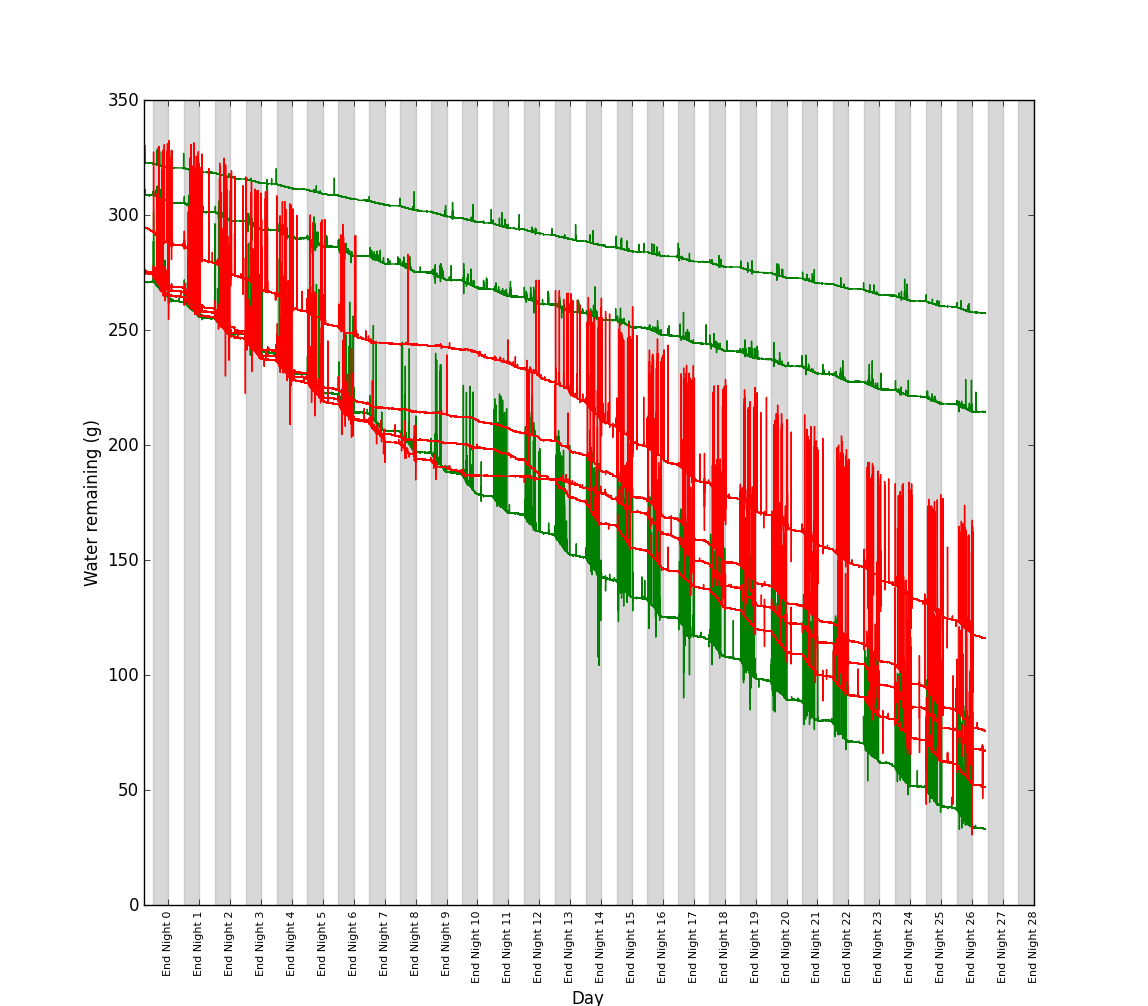

In [1]:
%matplotlib inline
from IPython.display import Image
Image('./drinking/water_usage_exp1.png')

# for y in [w1, w4, w7]:
#     plt.plot(t, y, 'g')
# for y in [w2, w5, w6, w8]:
#     plt.plot(t, y, 'r')
# plt.ylabel('Water remaining (g)')
# plt.xlabel('Day')
# plt.xticks([i[1] for i in e], ['End Night %s' % i for i in range(len(e))], rotation=90, size=8)
# for i in e:
#     plt.axvspan(i[0], i[1], color='gray', alpha=.3)
# plt.show()

For a ~25 day experiment, assuming the mouse drinks ~3ml=3g/d, we'd expect about 75g water loss. The top two traces show some loss of 65.35, and 94.3 grams. This is reasonable. The other traces show between 178 and 230g loss. We assume there is some amount of leakage. To test this, we ran the 'lickometers' without mice. 

### What does leakage look like?

The graph below shows 7 cages which had no mice but full water bottles over a period of approximately 88h. At about 50000, 60000, and 263000 seconds, there are sharp drops in all but the yellow signal, suggesting that drops of water were lost here. The yellow signal is from a cage whose controller was behaving strangely. 

In addition to the drops, the overall variability (~1g) of the water signal over time is seen. A downward trend in each signal suggests evaporative loss.

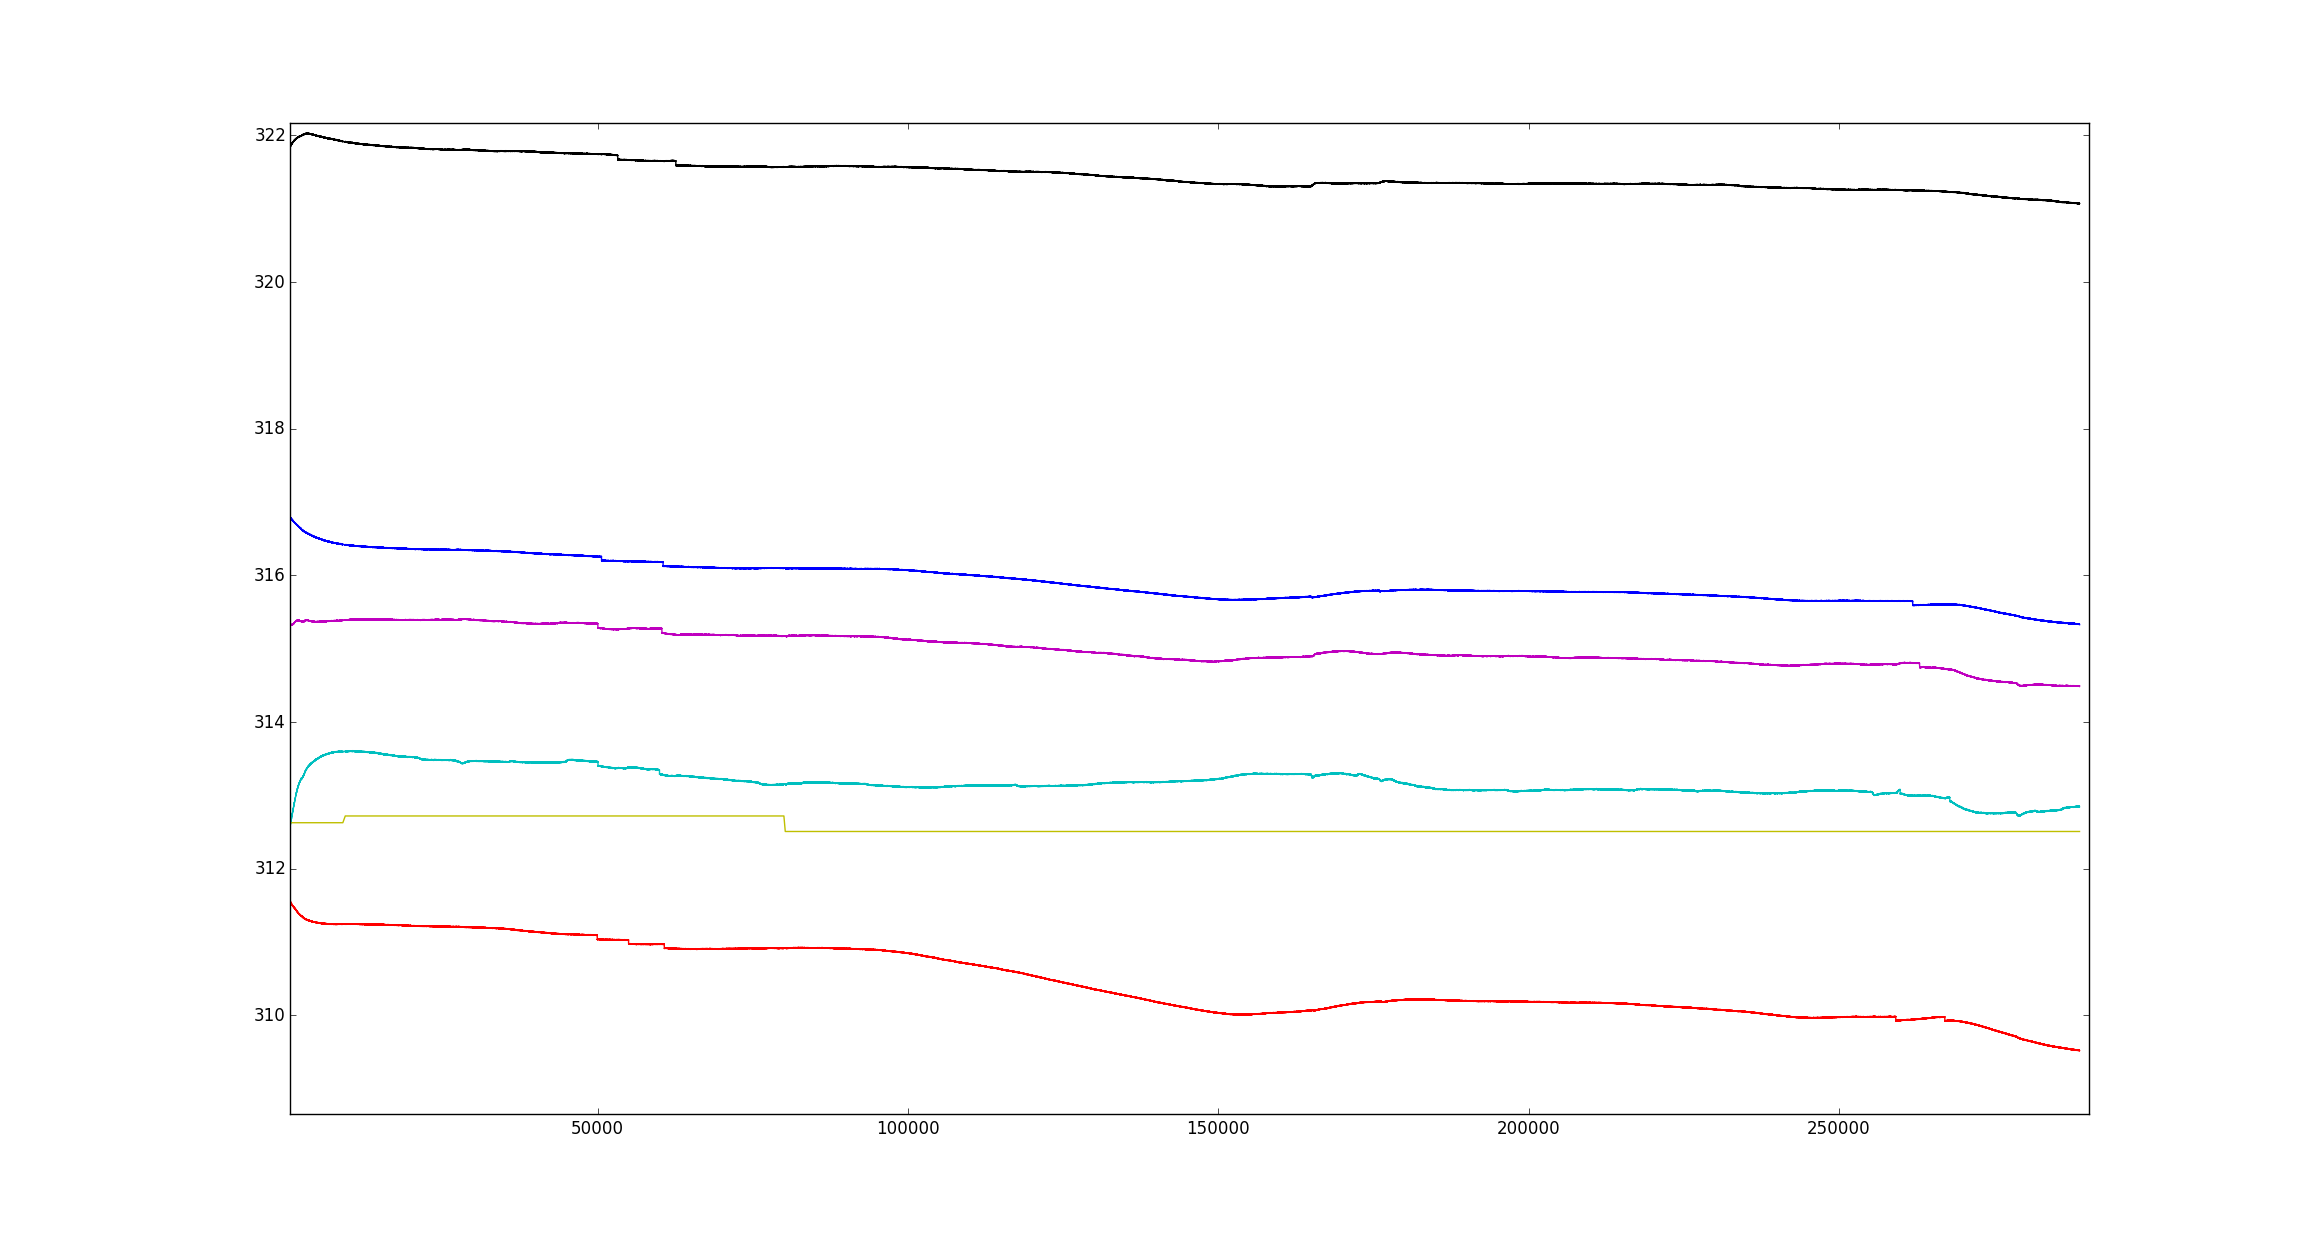

In [2]:
%matplotlib inline
from IPython.display import Image
Image('./drinking/no_animals_water_traces.png')

The above graph suggests that there are both evaporative events and loss of droplets. However, looking at the overall infection trace above suggests that there might be another mode of loss: interaction with the water bottle. To assess this we quantified the water loss per 12h period (aligned to the active/sleep cycle of the mice):

In [39]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from bcp.util import nights, days
from bcp.parse import convert_promethion_date

exp_start = convert_promethion_date('6/23/2015 11:46:44')
times = np.load('../data/exp1/time.npy')
water_traces = np.array([np.load(i) for i in glob.glob('../data/exp1/Water_*.npy')])
ns = nights(7, 12, exp_start, times[-1])
ds = days(ns, times[-1])

# Cast the actual seconds elapsed - i.e. what 'times' records -- into 
# the observations at those times.
ns = np.array([np.searchsorted(times, i) for i in ns])
ds = np.array([np.searchsorted(times, i) for i in ds])

# Calculate water loss per day and night; use a median around
# several points to ensure that a random spike doesn't pollute
# values
results = []
for day_start, day_end in ds.astype(int):
    wls = []
    for wt in water_traces:
        wl = np.median(wt[day_start: day_start + 60]) - \
             np.median(wt[day_end - 60: day_end])
        wls.append(wl)
    results.append(wls)
day_losses = np.array(results)

results = []
for night_start, night_end in ns.astype(int):
    wls = []
    for wt in water_traces:
        wl = np.median(wt[night_start: night_start + 60]) - \
             np.median(wt[night_end - 60: night_end])
        wls.append(wl)
    results.append(wls)
night_losses = np.array(results)


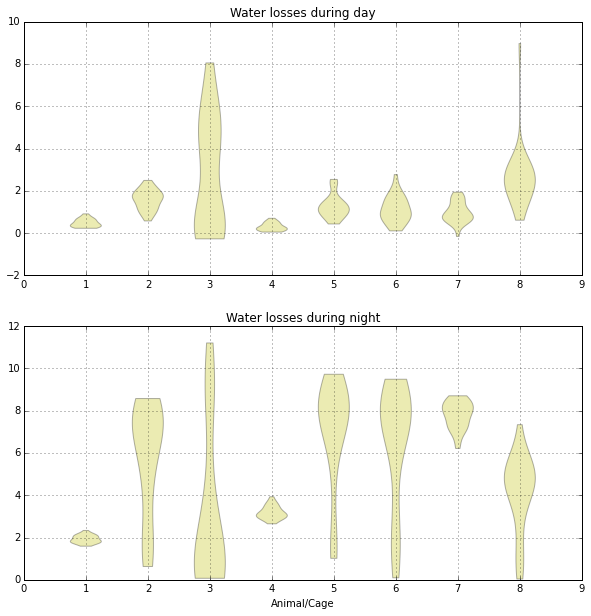

In [45]:
%matplotlib inline
f, axarr = plt.subplots(nrows=2, figsize=(10,10))
axarr[0].set_title('Water losses during day')
r = axarr[0].violinplot(day_losses, showextrema=False)
axarr[1].set_title('Water losses during night')
r = axarr[1].violinplot(night_losses, showextrema=False)
axarr[1].set_xlabel('Animal/Cage')
axarr[0].grid()
axarr[1].grid()
plt.show()

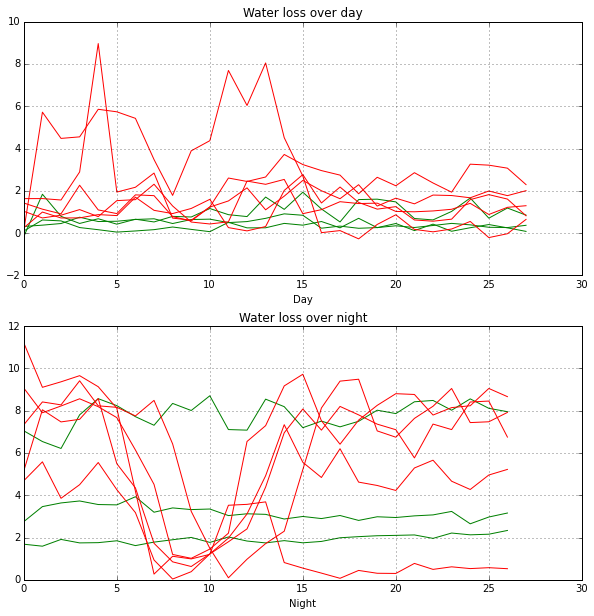

In [48]:
%matplotlib inline

nnights = night_losses.shape[0]
ndays = day_losses.shape[0]

f, axarr = plt.subplots(nrows=2, figsize=(10,10))
axarr[0].set_title('Water loss over day')
axarr[1].set_title('Water loss over night')
axarr[0].grid()
axarr[1].grid()
axarr[0].set_xlabel('Day')
axarr[1].set_xlabel('Night')
for i in [0, 3, 6]:
    axarr[0].plot(np.arange(ndays), day_losses[:, i], color='green')
    axarr[1].plot(np.arange(nnights), night_losses[:, i], color='green')
for i in [1, 2, 4, 5, 7]:
    axarr[0].plot(np.arange(ndays), day_losses[:, i], color='red')
    axarr[1].plot(np.arange(nnights), night_losses[:, i], color='red')
plt.show()

Water data from experiment 1 shows significant differences between mice unrelated to the infection status. In the cell below, the mice in green are healthy controls (1,4,7) and the mice in red are the infected mice (2,3,5,8, 6 is excluded because it died).

The traces for drinking events throughout the night look pretty uniform. Each drop in the weight appears to consist of a downward spike and then recovery as shown below. This image came from animal 1's water usage.

# What is a `true` drinking event?
To test the performance of our different methods of `lickometer` event classification, we need a ground truth dataset (some perfectly classified training data). To obtain training data we can use:
1. `Ethoscan` classifications from the Promethion software
2. Guess what a drinking event looks like and then manually classify traces
3. Take video of the mice during the night cycle using the raspberry pi and the pi noir camera and match interaction with the water hopper in the video feed to the weight trace feed from the cages

# Methods for extracting drinking events from raw data

The machine learning methods that we will use to determine health or sickness status will rely on features extracted from the direct measurements made by the Promethion cage. In the case of drinking, the perfect system would allow us to know if the animal was drinking (and how much) at any given second. In reality, this will be hard because of variability in the signals produced by the water sensors as well as the variability in drinking behaviors. We may have to settle for a method which will detect that a drink has occurred in the last x seconds. 

To validate our feature extraction methods we have two sources of data (other than our intuitition based on graphing the data):
1) Promethion ethovision software classification.
2) Monitoring mice with a camera in conjunction with recording from the cages. 

The methods we will use for feature extraction are:
1. K-means clustering
2. Wavelet analysis
3. Spectral analysis
4. HMM's
5. SVM, RF, etc?





## K-means clustering for feature extraction

Our initial attempt to classify events as drinking (so that we can count them, determine how much has been drunk, etc.) will be based on **`kmeans`** clustering. 

In general, we are attempting to build a **`codebook`** that has a set of signals (vectors) which *span* the space of signals recorded by the water sensor. We are particularly interested in finding something that can tell us when a drink has been taken. 

The `codebook` we are creating will depend very much on the length of the signal we are processing. If we process a collection of signals that are each 10 seconds long, they will look different in many ways than a collection of signals (from the same data) that are 100 seconds long.

At a high level, the input data are traces of water consumption. This means a 1D vector where the `ith` entry is the amount of water remaining in the cage at time `i` (more accurately `i` measurements since the start of the experiment). This data is split at regular intervals into sub-signals of length **`k`**. For instance, if we measured for 1005 seconds, and wanted to look for different signal types in the range of 10 seconds we'd split the data into 100 length 10 signals (and discard the 5 seconds at the end). We'd then have 100 independent vectors to run our computations on (i.e. to classify as closest to different members of our `codebook`).

The `scipy.cluster` documentation suggests that for kmeans clustering it is essential to normalize the columns of our signals matrix (i.e. the features of each vector) to have unit variance. To do this, we divide each column by it's standard deviation. 

We also subtract the mean of the data from each vector (each row). Tests without this subtraction show that the cluster centroids are picked mainly to accomodate the different data scales that happen. Specifically, the mean water level is ~300g at the start of the experiment and ~100g at the end of the experiment for some mice. The centroids picked when the data are not centered end up being far more determined by the general water level than the specific signal changes.


Below is an example of using K-means clustering to find the drinking events in a specific signal. This data is from mouse 1, using 5 clusters, 0 regularization value, and a signal length of 100. The top graph shows the actual water trace (in dark blue) and each window of 100 seconds is colored according to which of the k centroids that signal is closest too. You can see that many of the drops which we beleive to be drinking events are highlighted in either light blue or orange. This means that they are closer to the light blue and orange centroid than they are to the darker blue centroid (which appears to be the centroid representing flat signals).

The bottom graph shows the trace of the centroid vectors (i.e. the means). The green and purple centroid vectors don't show up in the top graph but are found in other parts of the the whole trace. Interestingly, the orange and blue centroids (which are classifying the feeding events) appear to have very constant values. The X axis on the bottom graph represents the position in the vector (so blue_centroid[50] is the closest value - in the sense of minimizing least squared error - to v[50] for all v which are in the blue cluster in the entire experiment).  

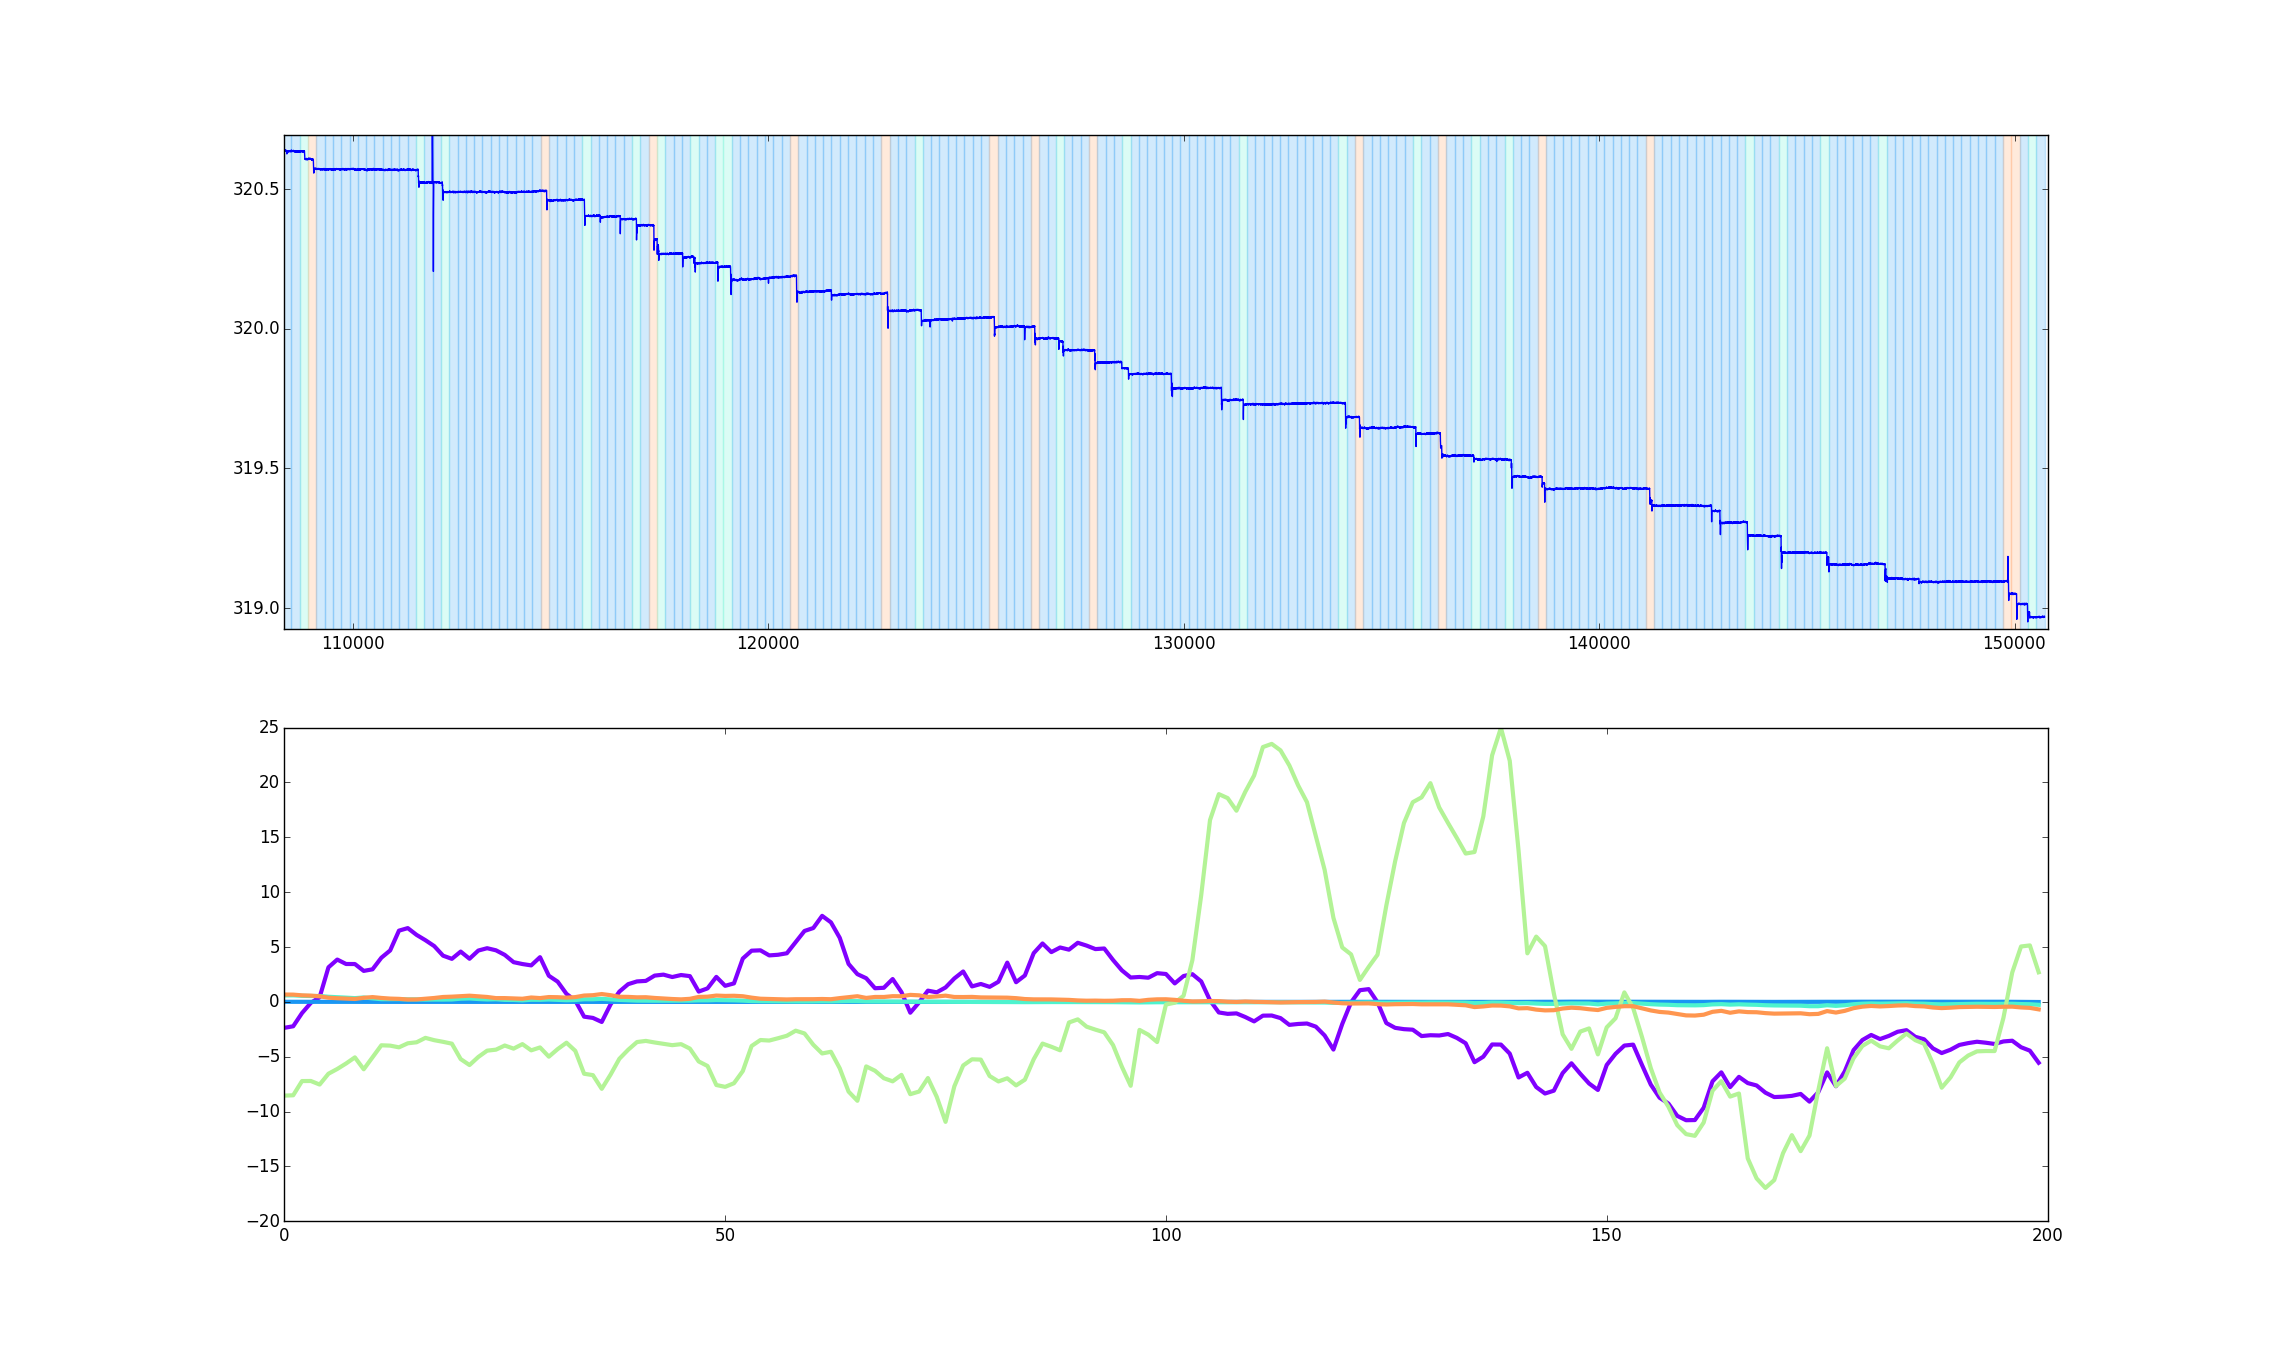

In [6]:
from IPython.display import Image
Image('./drinking/m1_k5_sl200.png')

### Can we improve k-means using noise reduction or moving averages?
Below is working code for building k means clustering using a variety of different additional filtration and regularization steps. It is the same data that generated the plot above, but with different parameters. 

The different approaches for preprocessing are **centered moving average** - just a window moving average, and positive spike removal - a process which we are using to remove the times when the mouse interacts with the device and causes an apparent spike well above background.

In [13]:
%matplotlib inline
from bcp.feature_extraction import trace_to_signals_matrix
from bcp.stats import centered_moving_average
from bcp.preprocess import (weight_sensor_positive_spikes, smooth_positive_spikes)
import numpy as np
from scipy.cluster.vq import kmeans, vq
import matplotlib.pyplot as plt

w1 = np.load('../data/exp1/Water_1.npy')
t = np.load('../data/exp1/time.npy')

# We are going to use only a small bit of the water trace.
start_ind = 110000
end_ind = 130000

# The signal_length is the length of the vectors we will use for the inputs to k-means.
# K is the number of vector centroids we have. 
signal_length = 100
k = 5

# Calculate the vectors for input to kmeans.
m_start_ind = start_ind / signal_length
m_end_ind = end_ind / signal_length

In [14]:
# Kmeans with no prior data smoothing. 
w1_sm = trace_to_signals_matrix(w1, signal_length, regularization_value=.001)
cb, _ = kmeans(w1_sm, k)
obs = w1_sm[m_start_ind: m_end_ind]
m, d = vq(obs, cb)

In [15]:
# Kmeans with center moving average applied to data
# The cma_radius indicates the window of the moving average around the given point. 
cma_radius = 5
w1_cma = centered_moving_average(w1, cma_radius)
# set the edges of the signals to what they would otherwise be.
# without this, there are significant effects on the set of kmeans.
w1_cma[:cma_radius] = w1[:cma_radius]
w1_cma[-cma_radius:] = w1[-cma_radius:]
w1_cma_sm = trace_to_signals_matrix(w1_cma, signal_length, regularization_value=.001)
cb_cma, _ = kmeans(w1_cma_sm, k)
obs_cma = w1_cma_sm[m_start_ind: m_end_ind]
m_cma, d_cma = vq(obs_cma, cb_cma)

In [16]:
# Kmeans with removal of spiking values as illustrated in trace above at roughly t=112000.
threshold = .3
spikes = weight_sensor_positive_spikes(w1, t, threshold)
backward_window = 10
forward_window = 5
w1_psr = smooth_positive_spikes(w1, spikes, backward_window, forward_window)
w1_psr_sm = trace_to_signals_matrix(w1_psr, signal_length, regularization_value=.001)
cb_psr, _ = kmeans(w1_psr_sm, k)
obs_psr = w1_psr_sm[m_start_ind: m_end_ind]
m_psr, d_psr = vq(obs_psr, cb_psr)

In [17]:
# Kmeans with removal of spiking values as illustrated in trace above at roughly t=112000
# and cma
threshold = .3
spikes = weight_sensor_positive_spikes(w1, t, threshold)
backward_window = 10
forward_window = 5
w1_psr = smooth_positive_spikes(w1, spikes, backward_window, forward_window)
cma_radius = 5
w1_psr_cma = centered_moving_average(w1_psr, cma_radius)
w1_psr_cma[:cma_radius] = w1[:cma_radius]
w1_psr_cma[-cma_radius:] = w1[-cma_radius:]
w1_psr_cma_sm = trace_to_signals_matrix(w1_psr_cma, signal_length, regularization_value=.001)
cb_psr_cma, _ = kmeans(w1_psr_cma_sm, k)
obs_psr_cma = w1_psr_cma_sm[m_start_ind: m_end_ind]
m_psr_cma, d_psr_cma = vq(obs_psr_cma, cb_psr_cma)

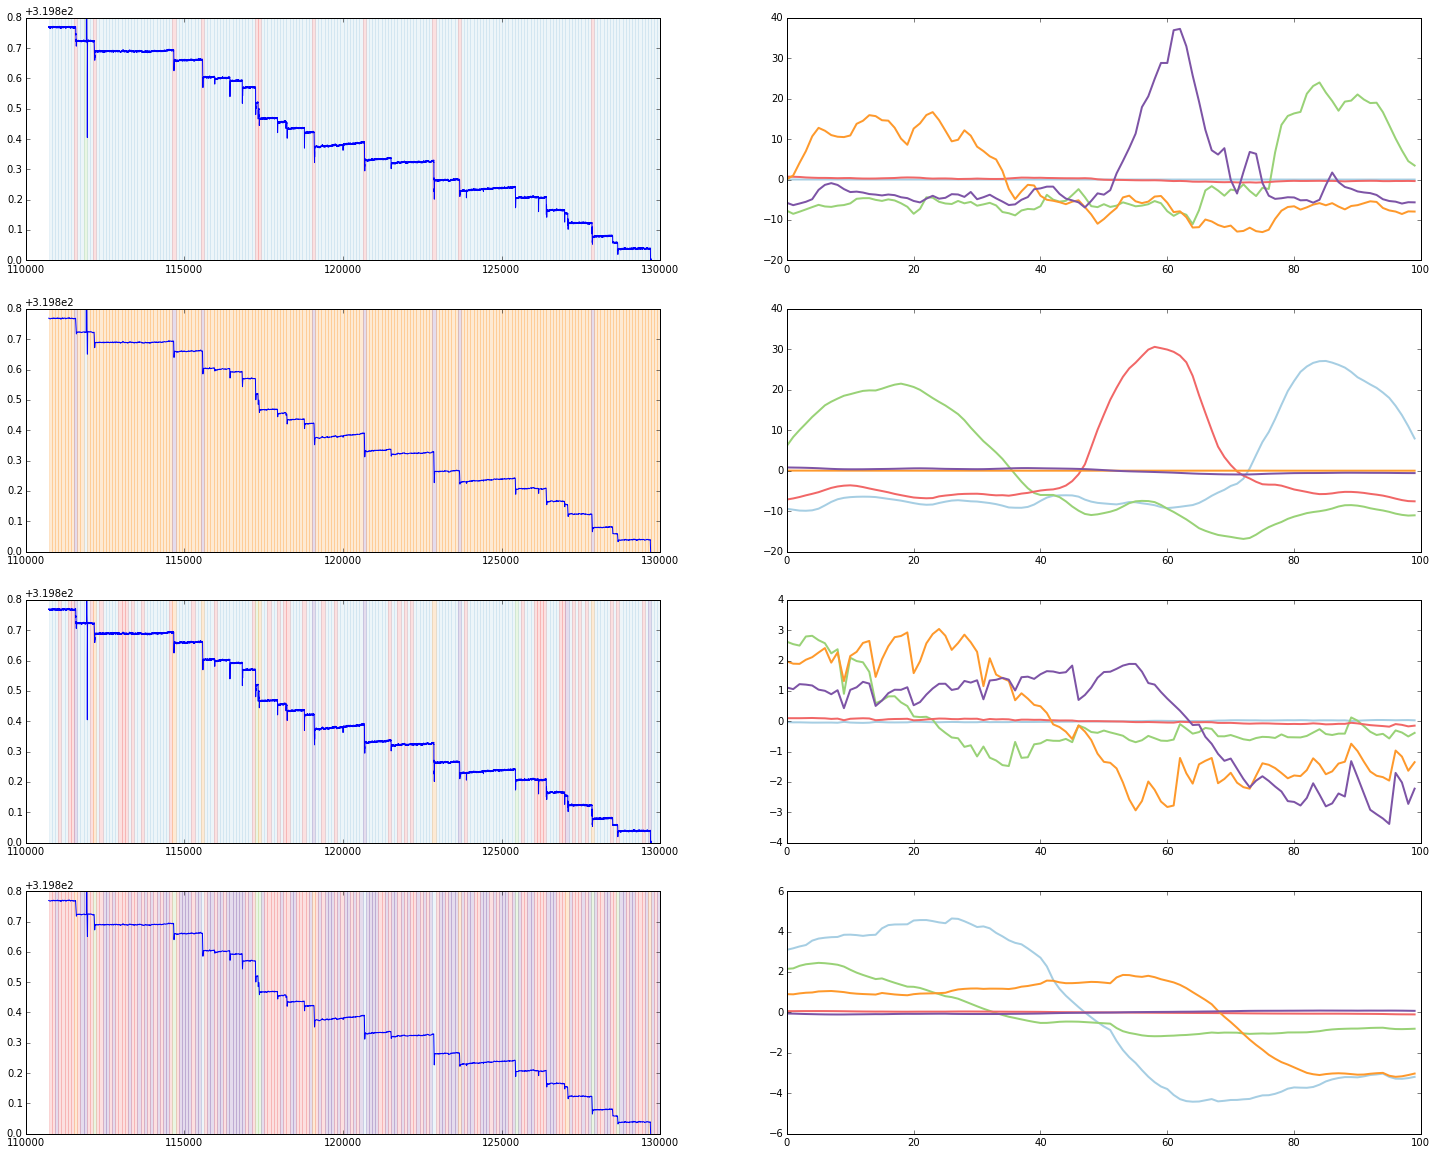

In [18]:
# plot results
ms = [m, m_cma, m_psr, m_psr_cma]
cbs = [cb, cb_cma, cb_psr, cb_psr_cma]
ws = [w1, w1_cma, w1_psr, w1_psr_cma]

colors = [plt.cm.Paired(i/float(k)) for i in range(k)]

f, axarr = plt.subplots(nrows=4, ncols=2, figsize=(25,20))

for i in range(4):
    axarr[i,0].plot(t[start_ind:end_ind], ws[i][start_ind:end_ind])
    for n in range(len(ms[i])):
        xmin_ind = start_ind + n * signal_length
        xmax_ind = xmin_ind + signal_length
        axarr[i, 0].axvspan(t[xmin_ind], t[xmax_ind], color=colors[ms[i][n]], alpha=.2)
    axarr[i, 0].set_xlim(start_ind, end_ind)
    axarr[i, 0].set_ylim(319.8, 320.6)

    for j in range(k):
        axarr[i, 1].plot(cbs[i][j], lw=2, color=colors[j])

plt.show()
# Number in each class in the entire data from mouse 1, and in just the subset we classified.
#print np.bincount(vq(_w1, cb)[0], minlength=k)
#print np.bincount(m, minlength=k)

# FFTs/DFTs

Another approach suggested by Katie's earlier work as well as the signal nature of the problem is to use discrete Fourier Transforms on the drinking data to attempt to pull out the drinking events/signal components.

[This link](http://www-elsa.physik.uni-bonn.de/~dieckman/DFT/DFT.html) is an excellent guide to Fourier transforms, and I have used it in conjunction with [this video series](https://www.youtube.com/watch?v=gZNm7L96pfY). 

The ultimate goal is similar to the **`k-means`** above; can we take water traces and detect where the drinking events are occuring? Below is the code that runs a Fourier transform on a water signal.

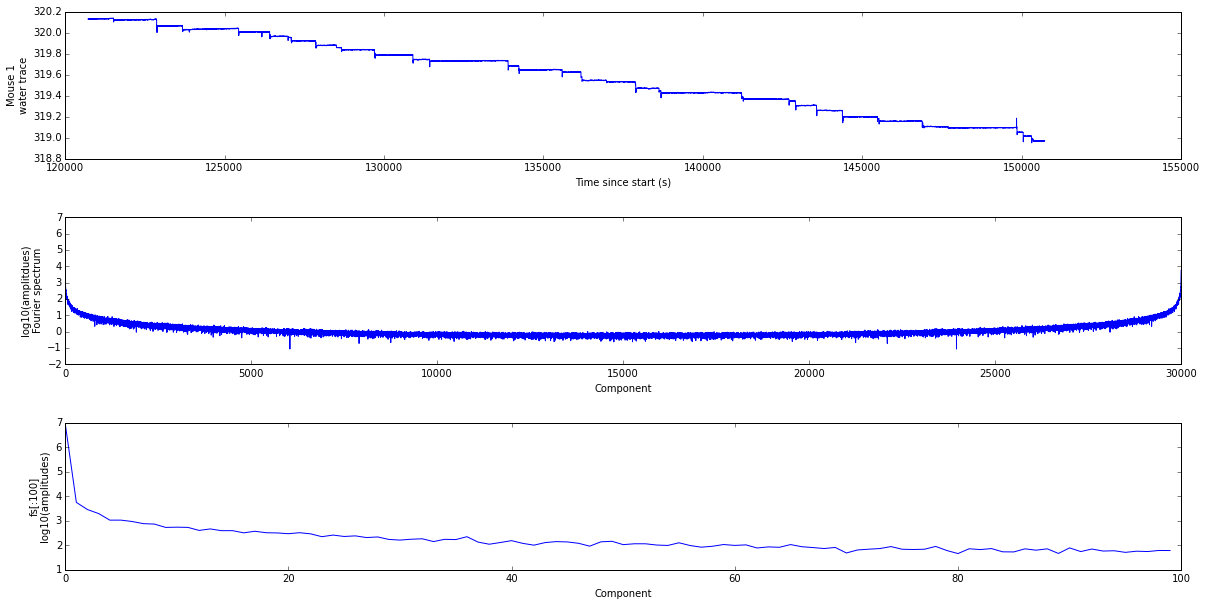

Top 10 Components (Magnitudes, Frequencies)
Component 0	110710.222034	0.0
Component 1	65.6457529714	3.33333333333e-05
Component 2	33.3699360098	6.66666666667e-05
Component 3	22.9063749984	0.0001
Component 4	12.3457035852	0.000133333333333
Component 5	12.3655651972	0.000166666666667
Component 6	10.8595499551	0.0002
Component 7	8.88028806637	0.000233333333333
Component 8	8.51196113806	0.000266666666667
Component 9	6.223466309	0.0003


In [29]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

w1 = np.load('../data/exp1/Water_1.npy')
t = np.load('../data/exp1/time.npy')

start = 120000
stop = 150000
data = w1[start:stop]

fs = np.fft.fft(data)
f, axarr = plt.subplots(nrows=3, figsize=(20,10))
axarr[0].plot(t[start:stop], data)
axarr[0].set_ylabel('Mouse 1\nwater trace')
axarr[0].set_xlabel('Time since start (s)')

axarr[1].plot(np.log10(np.abs(fs)))
axarr[1].set_ylabel('log10(amplitdues)\nFourier spectrum')
axarr[1].set_xlabel('Component')

axarr[2].plot(np.log10(np.abs(fs[:100])))
axarr[2].set_ylabel('fs[:100]\nlog10(amplitudes)')
axarr[2].set_xlabel('Component')

plt.subplots_adjust(hspace=.4)
plt.show()
print 'Top 10 Components (Magnitudes, Frequencies)'
for i in range(10):
    print '\t'.join(map(str, ['Component %s' % i, np.abs(fs[i])*(2./(stop-start)**.5), i/float(stop-start)]))

Notice that the components are generally decreasing with increasing frequency. This suggests that we mainly have low frequency phenomena (i.e. the general electronic noise in the system). There is symmetry around the 15000th component because of the way Fourier transforms work (the phase is exactly pi off). 

It is unclear if the Fourier transform can be useful for us in this context. 

When we conduct the Fourier transform on the entire water 1 trace we get the following image. Katie reported that when she conducted this analysis on feeding data, the highest amplitude component (other than a0) was one with a period of 24h = 1.1574074074074073e-05 Hz. 

For the below data, we find that the order of the most important components is: [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 27, 22, 23, 24, 26, 25, 29, 30, 28, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 47, 50, 49,
       51, 54, 52, 53, 56, 58, 57, 60, 59, 55, 61, 62, 63, 64, 65, 66, 67,
       69, 68, 70, 71, 72, 73, 81, 74, 78, 76, 75, 77, 80, 79, 83, 85, 84,
       82, 86, 89, 87, 88, 90, 94, 92, 93, 91, 96, 95, 98, 97, 99]

The frequency to component relationship is:
```
f = (s-1)/(stop-start)
f = 1.1574074074074073e-05
f * 2342138 +1 = 28.108078703703704
```
### Note the (s-1) component of the above formula may be an artifact of matlab's 1-based indexing. Check this.

Thus, we'd expect the 28th component to be the largest contribution if a signal with a period of 24h was dominant. It is in the top 30, but is not the first. This suggests that either I have done something wrong or the detrending of the overall signal would be required to see the 24h period.



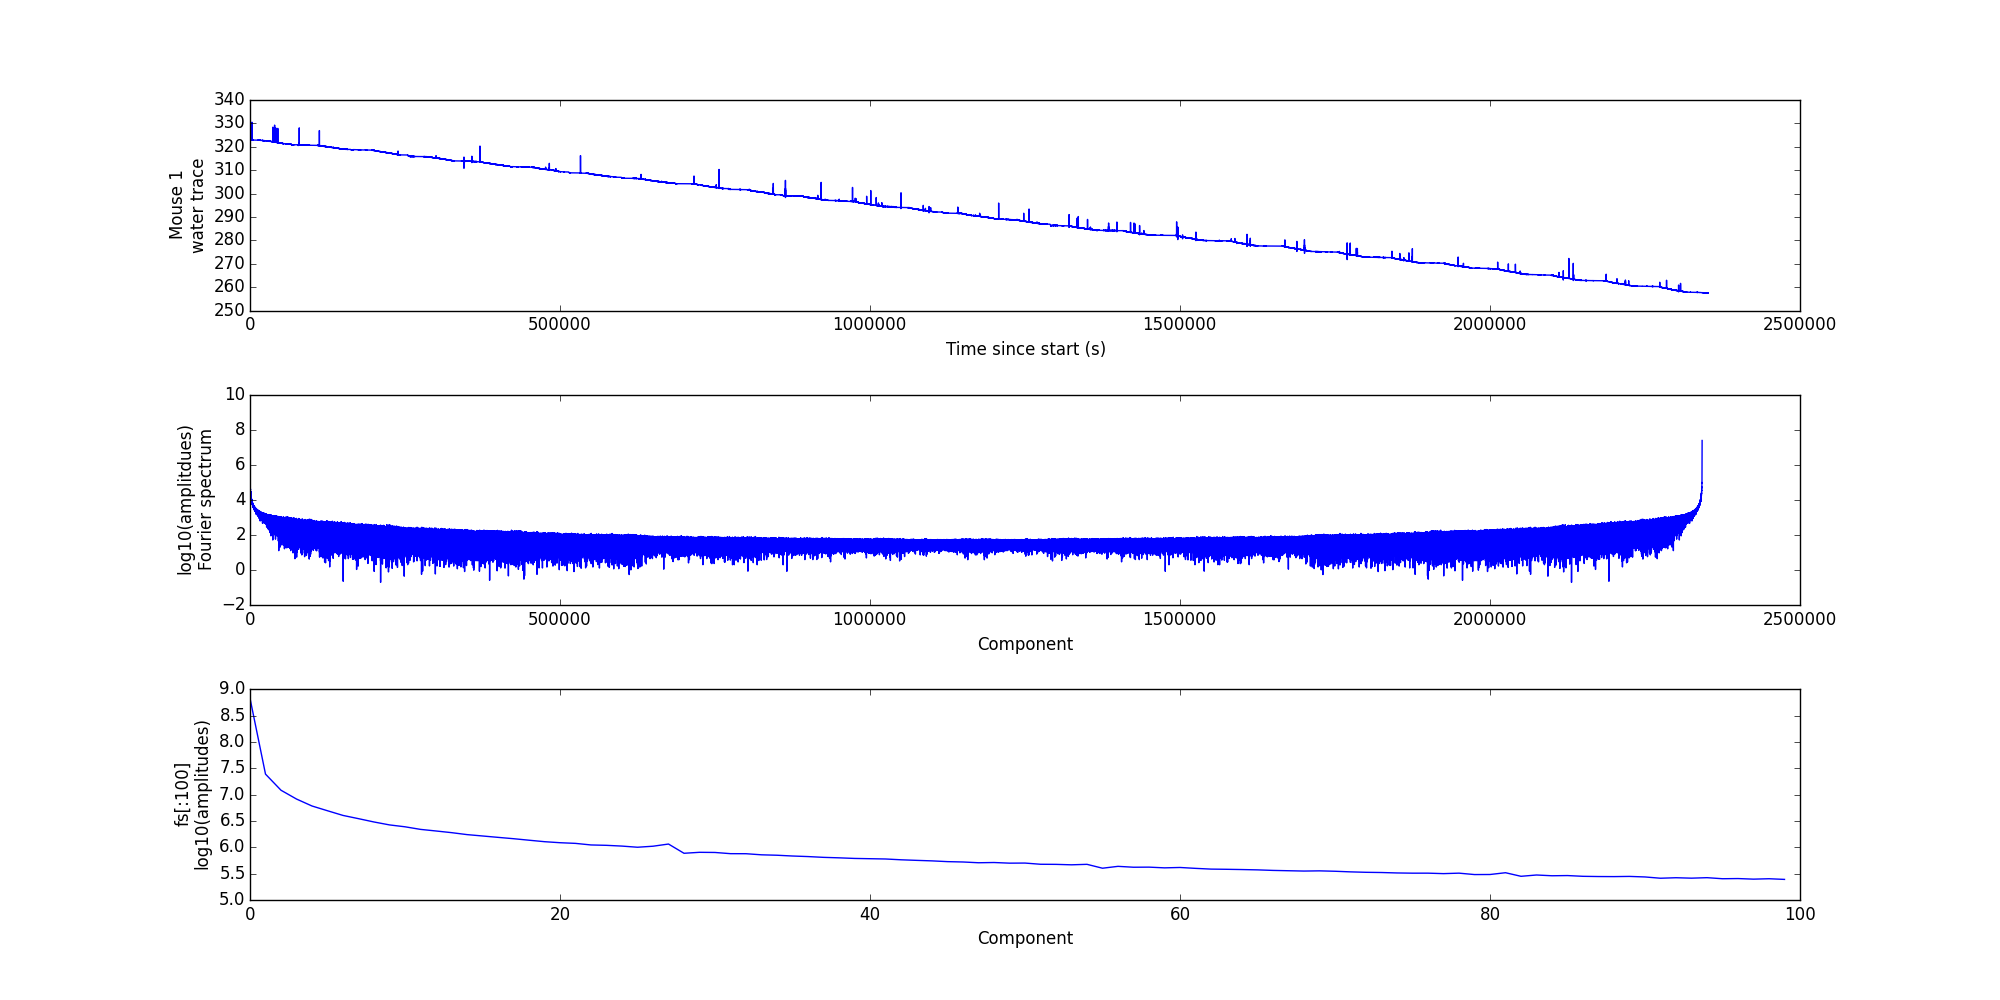

In [31]:
from IPython.display import Image
Image('./drinking/w1_fourier_spectrum.png')

# start = 0
# stop = 2342138
# data = w1[start:stop]

# fs = np.fft.fft(data)
# f, axarr = plt.subplots(nrows=3, figsize=(20,10))
# axarr[0].plot(t[start:stop], data)
# axarr[0].set_ylabel('Mouse 1\nwater trace')
# axarr[0].set_xlabel('Time since start (s)')

# axarr[1].plot(np.log10(np.abs(fs)))
# axarr[1].set_ylabel('log10(amplitdues)\nFourier spectrum')
# axarr[1].set_xlabel('Component')

# axarr[2].plot(np.log10(np.abs(fs[:100])))
# axarr[2].set_ylabel('fs[:100]\nlog10(amplitudes)')
# axarr[2].set_xlabel('Component')

# plt.subplots_adjust(hspace=.4)
# plt.show()
# print 'Top 10 Components (Magnitudes, Frequencies)'
# for i in range(10):
#     print '\t'.join(map(str, ['Component %s' % i, np.abs(fs[i])*(2./(stop-start)**.5), i/float(stop-start)]))

## Wavelet analysis

http://gtwavelet.bme.gatech.edu/wp/kidsA.pdf

https://www.eecis.udel.edu/~amer/CISC651/IEEEwavelet.pdf

http://jseabold.net/blog/2012/02/23/wavelet-regression-in-python/

https://www.youtube.com/watch?v=gZNm7L96pfY


# Random notes

It has been suggested that a moving average is the best filter for things in the time domain if you don't care about the frequency domain. See [this link](http://www.analog.com/media/en/technical-documentation/dsp-book/dsp_book_Ch15.pdf) in particular. 

It appears to be a very bad idea to pair a centered moving average with an FFT. As the following shows

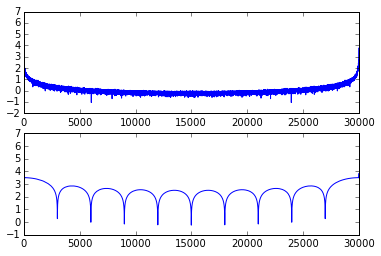

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from bcp.stats import centered_moving_average

w1 = np.load('/Users/wdwvt/Desktop/Sonnenburg/cumnock/bcp/data/exp1/Water_1.npy')
t = np.load('/Users/wdwvt/Desktop/Sonnenburg/cumnock/bcp/data/exp1/time.npy')

data = w1[120000:150000]
cma_data = centered_moving_average(data, 5)

f, axarr = plt.subplots(nrows=2)
axarr[0].plot(np.log10(np.abs(np.fft.fft(data))))
axarr[1].plot(np.log10(np.abs(np.fft.fft(cma_data))))
plt.show()

Clearly, the Fourier spectrum is significantly altered by the centered moving average, to the point where the signal makes little sense, 